In [1]:
from IF_functions import *
import os
import pandas as pd

In [2]:
#pth = r'\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\5xFAD 12MO F3-1_IF slide1'
pth = r'\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\WT 12MO F3-7_IF Slide1'

pth_tifs = os.path.join(pth, 'combined_ims')  # path of tif files of combined IF images (DAPI + other marker)
pth_coords = os.path.join(pth, 'cell_types_new') # path of xy coords of IF images

WSIs = sorted(glob(f'{pth_tifs}\*.tif'))

print(WSIs)

['\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\WT 12MO F3-7_IF Slide1\\combined_ims\\DAPI_Cy5.tif', '\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\WT 12MO F3-7_IF Slide1\\combined_ims\\DAPI_IBA.tif']


In [3]:
print(WSIs[0])
print(pth_coords)

\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\WT 12MO F3-7_IF Slide1\combined_ims\DAPI_Cy5.tif
\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\WT 12MO F3-7_IF Slide1\cell_types_new


In [4]:
Cy5_coords = load_var_from_mat(os.path.join(pth_coords, 'Cy5.mat'), "xy")

IBA_coords = load_var_from_mat(os.path.join(pth_coords, 'IBA.mat'), "xy")

In [5]:
adj_Cy5_coords = format_xy(Cy5_coords)
adj_IBA_coords = format_xy(IBA_coords)

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [7]:
WSIs[0]

'\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\WT 12MO F3-7_IF Slide1\\combined_ims\\DAPI_Cy5.tif'

In [8]:
# segment DAPI_Cy5 combined im
img = imread(WSIs[0])
img = img/255

labels_Cy5, polys_Cy5 = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 24/24 [00:42<00:00,  1.78s/it]


In [9]:
# segment DAPI_IBA combined im
img = imread(WSIs[1])
img = img/255

labels_IBA, polys_IBA = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


In [10]:
poly_Cy5_inds, xys_Cy5 = get_indices_shapes(polys_Cy5, adj_Cy5_coords)
poly_IBA_inds, xys_IBA = get_indices_shapes(polys_IBA, adj_IBA_coords)

In [11]:
# stardist got shapes for this ratio of positive cells
print(len(poly_Cy5_inds)/len(adj_Cy5_coords))

0.649519090644127


In [12]:
Cy5_polys = polys_Cy5['coord'][poly_Cy5_inds, :]
IBA_polys = polys_IBA['coord'][poly_IBA_inds, :]

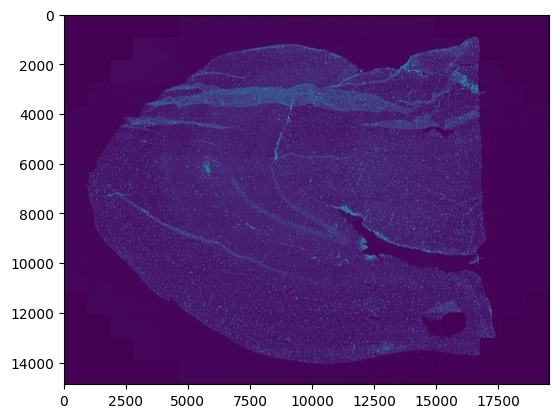

In [13]:
plt.imshow(img)

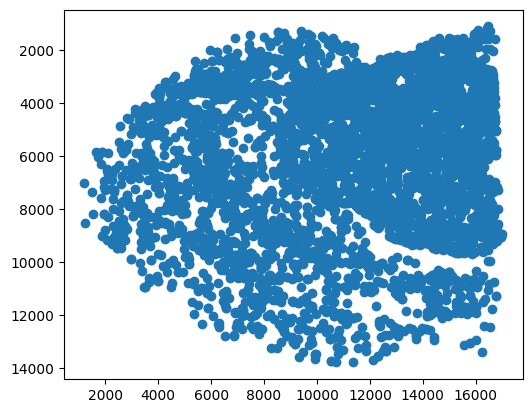

In [14]:
plt.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')

In [15]:
crop_x=12500
crop_y=10500

tile_size=1024*2

img = imread(WSIs[0])
img = img/255

cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

In [16]:
WSIs[0]

'\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\WT 12MO F3-7_IF Slide1\\combined_ims\\DAPI_Cy5.tif'

In [17]:
Cy5_polys[0]

array([[3668.        , 3670.62548828, 3673.05908203, 3675.15258789,
        3677.13061523, 3678.87036133, 3680.42822266, 3681.56665039,
        3682.5456543 , 3682.14135742, 3681.31396484, 3679.72705078,
        3677.86401367, 3675.74951172, 3673.30615234, 3670.62084961,
        3668.        , 3665.55224609, 3663.39697266, 3661.59545898,
        3660.03735352, 3658.6796875 , 3657.45336914, 3657.15063477,
        3656.44897461, 3656.38525391, 3655.37036133, 3655.03857422,
        3656.18920898, 3658.70629883, 3661.87036133, 3665.05200195],
       [3876.65356445, 3875.19873047, 3874.21337891, 3872.70458984,
        3871.13061523, 3869.26342773, 3867.14794922, 3864.69848633,
        3862.        , 3859.18701172, 3856.48510742, 3854.1640625 ,
        3852.13598633, 3850.40185547, 3849.18969727, 3848.82397461,
        3848.57275391, 3849.6940918 , 3850.88696289, 3852.41503906,
        3854.03735352, 3855.7722168 , 3857.6315918 , 3859.84204102,
        3862.        , 3864.31030273, 3867.2314

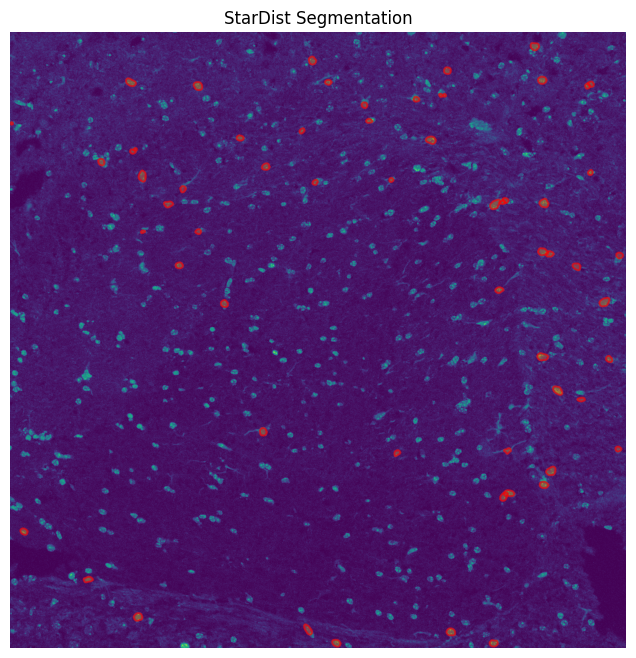

[614.4623414874077, 672.6290608048439, 367.07231017947197, 594.8768504559994, 447.22580736875534, 201.45452672243118, 293.92295467853546, 68.02401378750801, 47.45627072453499, 416.6763103455305, 267.2572391927242, 545.1024708300829, 208.90604650974274, 639.728654935956, 318.0803354009986, 757.1197659224272, 145.9085674136877, 549.9978588074446, 212.29822582006454, 489.33565935492516, 434.29854541271925, 613.8498410433531, 67.13441097736359, 225.0528725385666, 242.19225078821182, 214.7493869960308, 290.5185669064522, 231.55441668629646, 270.06148022413254, 94.90058900415897, 199.6987697929144, 257.196506395936, 565.1494439542294, 431.36573995649815, 387.9269744604826, 409.93331626057625, 382.042727984488, 88.66839770972729, 235.40875615924597, 376.9023423008621, 240.6066773608327, 551.5601599887013, 499.4798961058259, 500.6324354931712, 248.413092315197, 703.1980615183711, 620.7507097125053, 605.7807923182845, 454.32914459332824, 563.9736990779638, 492.2245055735111, 270.6037459000945, 

In [18]:
cropped_shapes_for_plot, areas_in_crop = get_valid_shapes_for_crop(Cy5_polys, crop_x, crop_y, tile_size)
plot_new_shapes(cropped_img, cropped_shapes_for_plot)
print(areas_in_crop)

In [26]:
# I switched get_indicies_shapes in the IF_functions.py file to return the xy coordinates now - 3/13/24 8:28 PM


Cy5_output = get_output_df(Cy5_polys)
IBA_output = get_output_df(IBA_polys)

In [27]:
xys_Cy5 = np.array(xys_Cy5)
xys_IBA = np.array(xys_IBA)

In [28]:
Cy5_output = pd.DataFrame({'x': xys_Cy5[:,1], 'y': xys_Cy5[:,0], 'Area':Cy5_output.iloc[:,2]})
IBA_output = pd.DataFrame({'x': xys_IBA[:,1], 'y': xys_IBA[:,0], 'Area':IBA_output.iloc[:,2]})

In [29]:
Cy5_output.head()

,x,y,Area
0,3665,3862,575.003938
1,3583,3961,124.167059
2,2778,6165,579.558658
3,3450,4731,291.882846
4,3427,4708,327.848480


In [30]:
IBA_output.head()

,x,y,Area
0,3614,3363,3231.241907
1,3701,3821,451.532540
2,3564,3563,482.091778
3,3475,3942,364.655611
4,3908,3750,285.454322


In [33]:
from scipy.io import savemat

nm = 'Cy5_coords_with_area.mat'
outpth = os.path.join(pth_tifs, 'x_y_area_mats')
if not os.path.exists(outpth): os.makedirs(outpth)

outnm = os.path.join(outpth, nm)

savemat(outnm, {'x_y_area':Cy5_output})

In [35]:
nm = 'IBA_coords_with_area.mat'
outnm = os.path.join(outpth, nm)

savemat(outnm, {'x_y_area':IBA_output})